# Aims of this script

1. Time-series visualisation of water levels
2. Calculating single value to use for interpolation approach
3. Any other time series analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
figures_directory = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures'

## Set up data

In [54]:
SAWaCoFolder = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\input_data\McLaren_SAWaterConnect'
constr_details_df = pd.read_csv(os.path.join(SAWaCoFolder, 'constructiondetails.csv'))
water_level_df = pd.read_csv(os.path.join(SAWaCoFolder, 'waterlevel.csv'))
well_summary_df = pd.read_csv(os.path.join(SAWaCoFolder, 'wellsummary.csv'))

outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

## Have a look at the well summary data and change index

In [4]:
well_summary_df.head(2)
print(well_summary_df.columns)
well_summary_df.index = well_summary_df.DHNO
print(well_summary_df.index)

Index(['DHNO', 'Unit_No', 'Unit_Number', 'dh_name', 'network', 'Obs_No',
       'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'rswl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_easting', 'mga_northing', 'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_long', 'decimal_lat', 'neg_decimal_lat',
       'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log'],
      dtype='object')
Int64Index([ 26532,  26542,  26547,  26548,  26558,  26565,  2

## Make the well summary into a geodataframe 

This allows for spatial plotting

In [5]:
well_summary_df["geometry"] = [Point(x, y) for x, y in zip(well_summary_df.mga_easting, well_summary_df.mga_northing)]

well_summary_gdf = gpd.GeoDataFrame(well_summary_df, geometry='geometry', crs= 'epsg:32754')

#print(well_summary_gdf.head(2))

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Have a look at the water level data and change the index 

Also change the format of the date time column for time-series analysis

In [6]:
water_level_df.head(1)

water_level_df.index = water_level_df.DHNO

print(water_level_df.index)

water_level_df["Datetime"] = pd.to_datetime(water_level_df["obs_date"])
#print(water_level_df["Datetime"])

Int64Index([ 26532,  26532,  26532,  26532,  26532,  26532,  26532,  26532,
             26532,  26532,
            ...
            200678, 200678, 200678, 200678, 200678, 200678, 200678, 200678,
            200678, 200679],
           dtype='int64', name='DHNO', length=24347)


## Create plots of water levels

Ensure only plotting where there are data - some of the wells there are no time series water level data available.

Save the plots in the figures directory.

In [7]:
idx = well_summary_df.index[0]

for idx in well_summary_df.index:
    #print(idx)

    df = water_level_df.copy()
    df = df[df["DHNO"]==idx]
    #print(df["rswl"])
    #print(df["rswl"].isnull())

    if (len(df) > 0) and (sum(~df["rswl"].isnull())>0):
        #print("Some data exist")
        #print(len(df))
        fig, axes = plt.subplots(1,1)
        df.plot("Datetime", "rswl", ax=axes, marker='+', ls="--",
                        markeredgecolor="0.1", label = idx) 
        #ax1.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2020-01-01'))
        axes.set_ylabel("RSWL (m AHD)")
        nm = "wl_%s" %idx
        plt.savefig(os.path.join(figures_directory, nm))
        plt.close()
    else:
        #print("No data available for well: %s" %idx)
        pass

## Plot location of wells

Text(84.43555954403271, 0.5, 'Northing')

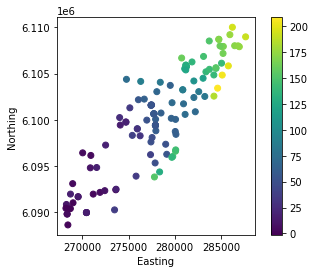

In [8]:
well_summary_gdf.plot(column="rswl", legend=True)
plt.xlabel("Easting")
plt.ylabel("Northing")

## Need to change the obs date to date time format 

This allows me to easily select samples only at/after/between specific time periods.  
First I need to first remove NAN values.  
ss = "sub-set" this is the subset of values corresponding to the time period I choose for the map.

In [9]:
well_summary_gdf_ss = well_summary_gdf.copy()

well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['water_level_date'].notna()]

print("Number of samples including nan values:" + str(len(well_summary_gdf)))
print("Number of samples exlcuding nan values:" + str(len(well_summary_gdf_ss)))

well_summary_gdf_ss["Datetime"] = pd.to_datetime(well_summary_gdf_ss["water_level_date"])

Number of samples including nan values:148
Number of samples exlcuding nan values:140


## Only get dates that are this year - so that they are consistent


In [57]:
startdate = '2021-01-01 00:00:00'

print("Total number of measurements, any time period %i" %(len(well_summary_gdf_ss)))
well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['Datetime'] > startdate]
print("Number of measurements after %s: %i" %(startdate[0:10], len(well_summary_gdf_ss)))

Total number of measurements, any time period 85
Number of measurements after 2021-01-01: 85


## Filter out empty values that don't have a rswl

In [67]:
well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['rswl'].isnull() == False]

print("Number of measurements after %s & with a rswl measurement: %i" %(startdate[0:10], len(well_summary_gdf_ss)))

Number of measurements after 2021-01-01 & with a rswl measurement: 81


### Plot the location of wells in 2021 with data for rswl

<AxesSubplot:>

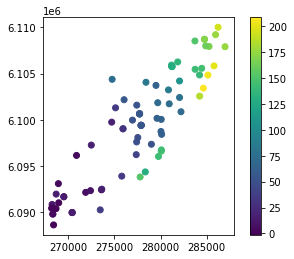

In [70]:
well_summary_gdf_ss.plot(column="rswl", legend=True)

### Export this dataframe for future reference

In [71]:
well_summary_gdf_ss.to_csv(os.path.join(outputdatapath, "well_summary_gdf_ss.csv"))

## Create experimental variogram

This is going to be to help us to do some form of interpolation with the data.

### Define the function

In [80]:
def make_variogram_wells(df, nbin):

    ### Matrix of the difference between distances 

    xx, xy = np.meshgrid(df["mga_easting"].to_numpy(), 
                        df["mga_easting"].to_numpy())

    dist_x = (xx - xy)**2

    #print(dist_x[:10, :10])


    yx, yy = np.meshgrid(df["mga_northing"].to_numpy(), 
                        df["mga_northing"].to_numpy())

    dist_y = (yx - yy)**2

    dxy = np.tril(np.sqrt(dist_x + dist_y)) 

    ### Matrix of the difference between values

    xv,yv = np.meshgrid(df["rswl"].to_numpy(), 
                        df["rswl"].to_numpy())

    dkv = np.tril(np.sqrt((xv-yv)**2)/2)
    #print(dkv[0:3, 0:3])

    ### Filter non-zero values and flatten array

    mask = np.nonzero(dxy*dkv) # All values in dxy and dkv that are not zero 
    dxy_masked = dxy[mask]
    dkv_masked = dkv[mask]

    ### Sort arrays (together)

    sort_ix = dxy_masked.argsort()
    dxy_sort = dxy_masked[sort_ix]
    dkv_sort = dkv_masked[sort_ix]
    ssz = int(dxy_masked.size/nbin)

    ### Create x and y values for semivariogram

    L,x,y = [0.],[],[]
    for i in range(int(len(dxy_sort)/ssz)):

        x_all = dxy_sort[i*ssz:(i+1)*ssz]    
        y_all = dkv_sort[i*ssz:(i+1)*ssz]

        x.append( np.sum(x_all)/len(x_all) )
        y.append( np.sum(y_all)/len(y_all) )
        L.append( x_all[-1] )

    x,y = np.array(x),np.array(y)

    return x, y, ssz, L

### Make the variogram by running the function

In [81]:
nbin = 100
x_wt, y_wt, ssz_wt, L_wt = make_variogram_wells(well_summary_gdf_ss, nbin)

### Plot the "real" variogram


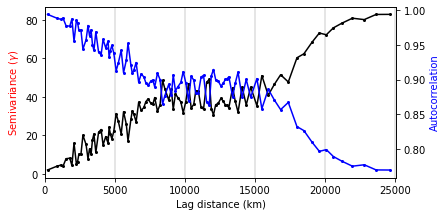

In [84]:
x = x_wt
y = y_wt
ssz = ssz_wt
L = L_wt

figx = 16.
f = plt.figure( figsize=[figx/2.54, figx/2.54/2.00] )
s = f.add_subplot(1,1,1)
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')

# Plot semi-variance
s.plot( x, y, 'o-', c='k', ms=2, mec='k', mfc='k' )

# Plot autocorrelation
s2 = s.twinx()
s2.plot( x, 1.-(y/np.var(y)), 'o-', c='b', ms=2, mec='b', mfc='b' )

# Plot set up
s.xaxis.grid(color='k', linestyle='-', lw=0.2)
s.set_xlim( -.001, L[-1]+0.001 ) 
s.set_xlabel('Lag distance (km)')
s.set_ylabel('Semivariance (${\gamma}$)', color='r')

s2.set_ylabel('Autocorrelation', color='b')

plt.savefig(os.path.join(figures_directory, "exp_variogram"))

# Below = MESSY/SCRAPPY

In [33]:
well_summary_gdf['water_level_date']

well_summary_gdf_ss = well_summary_gdf.copy()

for ix in well_summary_gdf_ss.index:
    obs_date = well_summary_gdf_ss.loc[ix, 'water_level_date']
    #print(obs_date)
    #print(type(obs_date))
    #print(pd.isna(obs_date))
    
print(pd.isna('nan'))

False
